In [1]:
'''
补丁脚本，主要有两个任务：
1.讨论与均匀下采样相关的问题；
2.用预处理的数据模拟轮廓线重建、结果可视化的流程。
'''

import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/李娅宁/9月下旬项目重开"
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())


当前工作目录： C:\Users\HP
修改后的工作目录： D:\李娅宁\9月下旬项目重开


In [2]:
'''
关于均匀下采样：

从原理上来说，只要不改变点云坐标，就没有绝对的均匀采样；泊松采样、最远点采样等方法都能实现不完美的均匀采样。
因此可以先用以前的最远点采样代码代替随机采样，或者干脆继续用随机采样，由于点云不是非常不均匀，随机采样的影响不会太大。

使用下采样会在绘制预备体表面三角面片时引入新问题————必须重新生成下采样后点云的拓扑图和三角面片。这个问题根植于当前版本Point Net ++的预测方式当中。
在不修改Point Net ++的前提下，解决新问题的思路有两条：
①专门编写一个为采样后点云生成三角面片的函数；
②专门编写一个特征传输函数（比如用邻域投票法），为原始点云/插值加密点云中的每个点赋予标签。
'''

# 我试了一下方案①，效果不好，不如直接用邻域投票做上采样，如果边缘不平滑还可以再配合形态学操作
# 方案②有一个简单的实现方式：可以在下采样时记录采样点的索引sampled_indices，完成预测后先在原始点云中为sampled_indices对应的点复制标签，随后使用邻域投票法为剩余点赋予标签

import numpy as np

def furthest_point_sampling(points, num_samples):
    """
    从给定的点中选择最远点采样。
    :param points: 输入的点集合，形状为 (N, D)，N为点的数量，D为维度（2或3）。
    :param num_samples: 需要采样的点数量。
    :return: 选中的最远点索引的集合和坐标的集合。
    """
    N, D = points.shape
    # 初始化已选择的点集合
    sampled_indices = np.zeros(num_samples, dtype=int)
    
    # 随机选择第一个点
    sampled_indices[0] = np.random.randint(0, N)
    
    # 计算第一个样本到所有点的距离
    distances = np.linalg.norm(points - points[sampled_indices[0]], axis=1)

    for i in range(1, num_samples):
        # 选择距离已选点集中最远的点
        sampled_indices[i] = np.argmax(distances)
        
        # 更新距离
        new_distances = np.linalg.norm(points - points[sampled_indices[i]], axis=1)
        distances = np.minimum(distances, new_distances)

    return sampled_indices, points[sampled_indices]

'''
sampled_indices在某个索引a处的值为b，代表下采样点云中的点a正是原始点云中的点b。
预测过程省略，假设预测后得到的标签数组为predicted_labels。
'''

def calculate_parts(predicted_labels, sampled_indices):
    '''生成原始点云中各组件的索引名单，这个函数我没有做测试'''
    parts = []
    for i in range(8):
        temp = np.where(predicted_labels == i+1)[0].tolist()
        parts.append(sampled_indices[temp])
    return parts
    
def perform_voting(vertices, parts):
    """
    为点云数据中的每个点分配标签，确保每个 part 的标签与其索引一致，同时使用投票机制对未标记的点进行标签分配。
    
    参数:
    vertices: 点云数据，形状为 (n, 3)，每行表示一个点的 (x, y, z) 坐标。
    parts: 列表，包含每个分区的点的索引列表。
    
    返回:
    labels: 点的标签，形状为 (n,)，每个标签是一个整数。
    """
    # 创建 KDTree 以高效地查找邻域
    tree = KDTree(vertices)
    
    # 创建标签数组
    labels = np.zeros(len(vertices), dtype=int)
    
    # 为每个 part 分配标签
    for i, part in enumerate(parts):
        for idx in part:
            labels[idx] = i + 1  # 标签从1开始
    
    # 临时标签数组用于存储投票结果
    temp_labels = np.zeros(len(vertices), dtype=int)
    
    # 设置邻域半径的初始值和最大值
    r_min = 0.2
    r_max = 1
    r_increment = 0.2
    
    # 对每个未标记的点进行投票
    for i, vertex in enumerate(vertices):
        if labels[i] > 0:
            continue  # 跳过已经标记的点
        
        # 初始化邻域半径
        r = r_min
        found_valid_neighbor = False
        
        while r <= r_max:
            # 查找邻居
            neighbors, distances = tree.query_radius([vertex], r=r, return_distance=True)
            neighbors = neighbors[0]  # 提取索引数组
            distances = distances[0]  # 提取距离数组
            
            # 只考虑已标记的邻居进行投票
            valid_neighbors = neighbors[labels[neighbors] > 0]
            valid_distances = distances[labels[neighbors] > 0]
            
            if len(valid_neighbors) > 2:  # 确保有足够的有效邻居
                found_valid_neighbor = True
                break
            r += r_increment
        
        if not found_valid_neighbor:
            continue

        # 如果找到有效邻居，进行标签投票
        neighbor_labels = labels[valid_neighbors]
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        
        if len(unique_labels) > 0:
            # 获取最高计数的标签
            max_count = np.max(counts)
            candidates = unique_labels[counts == max_count]
            
            if len(candidates) > 1:  # 如果有多个标签计数相同，选择平均距离最小的标签
                avg_distances = np.array([np.mean(valid_distances[neighbor_labels == label]) for label in candidates])
                best_label = candidates[np.argmin(avg_distances)]
            else:
                best_label = candidates[0]
            
            temp_labels[i] = best_label
    
    # 更新最终标签
    labels[temp_labels > 0] = temp_labels[temp_labels > 0]
    
    return labels


In [3]:
'''
轮廓线重建
'''

# 1.准备数据
import chardet
import numpy as np
import networkx as nx

def detect_encoding(file_path):
    '''检测文件的encoding方式'''
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']
        
def load_obj_file(file_path, encoding):
    '''读取obj文件中的点云坐标，输出是list'''
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return vertices, faces

def insert_midpoint_points(vertices, faces, minimum_vertices_number=3000):
    if len(vertices) >= minimum_vertices_number:
        print('原始点云的点数足够多')
        return vertices, faces

    else:
        temp = 0
        while len(vertices) < minimum_vertices_number:
            edge_to_midpoint = {}
            new_points = []
            new_faces = []
            vertex_offset = len(vertices)
    
            for face in faces:
                # Compute midpoints for each edge
                midpoints = []
                for i in range(len(face)):
                    edge = tuple(sorted((face[i], face[(i + 1) % len(face)])))
                    if edge not in edge_to_midpoint:
                        midpoint = np.mean([vertices[edge[0]], vertices[edge[1]]], axis=0)
                        edge_to_midpoint[edge] = vertex_offset + len(new_points)
                        new_points.append(midpoint.tolist())
                    midpoints.append(edge_to_midpoint[edge])
                
                # Original vertices
                v0, v1, v2 = face
                # Midpoints
                m0, m1, m2 = midpoints

                # Create four new faces
                new_faces.append([v0, m0, m2])
                new_faces.append([v1, m1, m0])
                new_faces.append([v2, m2, m1])
                new_faces.append([m0, m1, m2])
    
            vertices.extend(new_points)
            faces = new_faces
            temp += 1

        print(f'使用了 {temp} 轮插值来让点云点数满足要求')
        
    return vertices, faces

def load_labeled_point_cloud(file_path):
    '''读取点云数据和标签'''
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def generate_graph(vertices, faces):
    """
    生成点云的拓扑图。
    """
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i + 1) % len(face)])
    return G


In [4]:
obj_file_path = "肩台外侧点-0715/1/1_1.obj"
txt_file_path = "多分类预处理0930/预处理结果文档/1_1.txt"
obj_encoding = detect_encoding(obj_file_path)
obj_vertices, obj_faces = load_obj_file(obj_file_path, obj_encoding)
checked_vertices, faces = insert_midpoint_points(obj_vertices, obj_faces, 5000)  # 对点数小于5000的点云做插值加密
vertices, labels = load_labeled_point_cloud(txt_file_path)
G = generate_graph(vertices, faces)


使用了 1 轮插值来让点云点数满足要求


In [5]:
'''
此处或许需要加入形态学操作，尤其是使用投票法做上采样的场合，形态学操作可以平滑区域边界。
形态学操作有灰度和彩色两种，之前是用灰度版，操作的值是各标签的概率。此处如有需求则需重新设计方案。
'''


'\n此处或许需要加入形态学操作，尤其是使用投票法做上采样的场合，形态学操作可以平滑区域边界。\n形态学操作有灰度和彩色两种，之前是用灰度版，操作的值是各标签的概率。此处如有需求则需重新设计方案。\n'

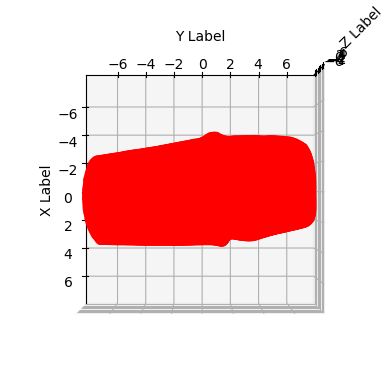

18218
18218


In [6]:
# 检查读取的数据
import matplotlib.pyplot as plt

def temp_plot(removed_points):
    # 绘制这些点
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(removed_points[:, 0], removed_points[:, 1], removed_points[:, 2], c='r', marker='.')
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    # 保持原始点云各轴比例一致
    max_range = np.array([removed_points[:, 0].max() - removed_points[:, 0].min(),
                          removed_points[:, 1].max() - removed_points[:, 1].min(),
                          removed_points[:, 2].max() - removed_points[:, 2].min()]).max() / 2.0
    
    mid_x = (removed_points[:, 0].max() + removed_points[:, 0].min()) * 0.5
    mid_y = (removed_points[:, 1].max() + removed_points[:, 1].min()) * 0.5
    mid_z = (removed_points[:, 2].max() + removed_points[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    # 设置视角
    ax.view_init(elev=90, azim=0)
    
    plt.show()

temp_plot(vertices)

print(len(checked_vertices))
print(len(vertices))

In [7]:
# 2.识别各面及其边界
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

def largest_connected_component(G, nodes):
    '''找出某标签的最大的连通子图'''
    subgraph = G.subgraph(nodes)
    largest_cc = max(nx.connected_components(subgraph), key=len)
    return subgraph.subgraph(largest_cc)

def get_max_connected_subgraphs(G, labels, target_labels):
    '''找到各标签的最大连通子图'''
    subgraphs = {}
    for label in target_labels:
        nodes = [i for i, l in enumerate(labels) if l == label]
        if nodes:
            largest_cc = largest_connected_component(G, nodes)
            subgraphs[label] = largest_cc
    return subgraphs

def find_boundary_edges(G, subgraph1, subgraph2):
    '''找到某两个标签之间的边界线'''
    boundary_edges = []
    for edge in G.edges():
        if (edge[0] in subgraph1 and edge[1] in subgraph2) or (edge[0] in subgraph2 and edge[1] in subgraph1):
            boundary_edges.append(edge)
    return boundary_edges

def get_all_boundary_edges(G, subgraphs):
    '''找到所有的边界线'''
    all_boundary_edges = {}
    for i in range(7):
        for j in range(i+1,8):
            all_boundary_edges[ (i+1,j+1) ] = find_boundary_edges(G, subgraphs[i+1], subgraphs[j+1])
    return all_boundary_edges

def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

def plot_surface_with_boundary_lines(vertices, faces, labels, boundary_edges, view_angles=(30, 30), angles=(0, 0, 0)):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    vertices = np.array(vertices)
    faces = np.array(faces)
    
    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    # 绘制不同标签区域的点云。此算法的缺点在于无法给三角标签各不相同的面染色
    # ['Ya Gen', 'Qie Duan', 'Jin Zhong', 'Yuan Zhong', 'She Zhou Mian', 'Chun Mian', 'Jian Tai', 'She Mian Wo']
    colors = ['cornflowerblue', 'cornflowerblue', 'lightgreen', 'lightgreen', 'white', 'honeydew', 'honeydew', 'honeydew']
    for i in range(8):
        part_faces = [face for face in faces if sum(labels[vertex] == i+1 for vertex in face) > 1]
        if len(part_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part_faces, color=colors[i], alpha=0.8)
    
    # 绘制边界线
    for i in range(7):
        for j in range(i+1,8):
            for edge in boundary_edges[(i+1,j+1)]:
                p1, p2 = vertices[list(edge)]
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red', lw=1)
    
    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Boundary Lines')

    # 确保坐标轴刻度一致
    x, y, z = vertices.T
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 显示图像
    plt.show()


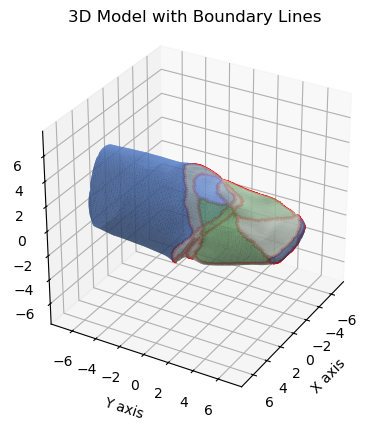

In [8]:
# 找到最大连通子图
target_labels = [1, 2, 3, 4, 5, 6, 7, 8]
subgraphs = get_max_connected_subgraphs(G, labels, target_labels)

# 找到边界线
all_boundary_edges = get_all_boundary_edges(G, subgraphs)

# 绘制点云及边界线，此处给了几组不同的姿态参数
plot_surface_with_boundary_lines(vertices, faces, labels, all_boundary_edges, view_angles=(30, 30), angles=(np.radians(-10), np.radians(0), np.radians(0)))
# plot_surface_with_boundary_lines(vertices, faces, labels, all_boundary_edges, view_angles=(30, 30), angles=(np.radians(88), np.radians(0), np.radians(160)))


In [9]:
'''
这是个半成品，存在两个问题：
1.对开放的轮廓线上的点，暂未找到合适的排序方式；
2.对太短的轮廓线，插值不足以复原真实轮廓。

解决思路是：
只重建那些对测量参数有意义的大轮廓线，甚至不使用插值复原，而直接用毛刺轮廓线做下一步的计算参数。
至于小轮廓线则可以用前一步得到的毛刺边代替，只需插值加密到边长足够短，毛刺就可以足够细小。
'''

# 3.重建轮廓线
from scipy.interpolate import CubicSpline
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter1d

# 局部加权平滑函数
def local_weighted_smooth(x, y, z, window_size=5, sigma=1.0):
    def smooth1d(data, window_size, sigma):
        smoothed = np.copy(data)
        for i in range(len(data)):
            start = max(0, i - window_size // 2)
            end = min(len(data), i + window_size // 2 + 1)
            weights = np.exp(-0.5 * ((np.arange(start, end) - i) ** 2) / sigma ** 2)
            weights /= weights.sum()
            smoothed[i] = np.dot(weights, data[start:end])
        return smoothed

    x_smoothed = smooth1d(x, window_size, sigma)
    y_smoothed = smooth1d(y, window_size, sigma)
    z_smoothed = smooth1d(z, window_size, sigma)
    
    return x_smoothed, y_smoothed, z_smoothed

# 计算边界线中点
def calculate_midpoints(boundary_edges, vertices):
    midpoints = []
    for edge in boundary_edges:
        p1, p2 = vertices[list(edge)]
        midpoint = (p1 + p2) / 2
        midpoints.append(midpoint)
    return np.array(midpoints)

# 通过最近邻方法排序点，这个排序不对，只适用于外颈缘线
def order_points(points):
    points = np.array(points)
    if len(points) < 2:
        return points
    
    n = points.shape[0]
    ordered_points = [points[0]]
    visited = {0}
    
    for _ in range(1, n):
        last_point = ordered_points[-1].reshape(1, -1)
        distances = distance_matrix(last_point, points)[0]
        distances[list(visited)] = np.inf
        next_point_index = np.argmin(distances)
        visited.add(next_point_index)
        ordered_points.append(points[next_point_index])
    
    return np.array(ordered_points)
    '''
    # 极角排序
    centered_aligned_marks1 = aligned_marks1 - np.mean(aligned_marks1)
    angles = np.arctan2(centered_aligned_marks1[:, 2], centered_aligned_marks1[:, 0])
    sorted_indices = np.argsort(angles)
    ordered_marks = aligned_marks1[sorted_indices]
    '''
# 拟合平滑曲线
def fit_smooth_curve(i, points, num_points=100, smooth_factor1=1.0, window_size=5, smooth_factor2=2):
    if len(points) < 2:
        return points
    
    ordered_points = order_points(points)
    x_new = ordered_points[:, 0]
    y_new = ordered_points[:, 1]
    z_new = ordered_points[:, 2]
    
    # Apply local weighted smoothing
    x_smoothed, y_smoothed, z_smoothed = local_weighted_smooth(x_new, y_new, z_new, window_size, smooth_factor1)
    
    # Apply Gaussian filter to smooth the curve
    x_smoothed = gaussian_filter1d(x_smoothed, sigma=smooth_factor2)
    y_smoothed = gaussian_filter1d(y_smoothed, sigma=smooth_factor2)
    z_smoothed = gaussian_filter1d(z_smoothed, sigma=smooth_factor2)
    
    if i ==0:
        # 针对牙根和肩台的环形分界线，令平滑后的插值线成环
        x_smoothed = np.concatenate([x_smoothed, [x_smoothed[0]]])
        y_smoothed = np.concatenate([y_smoothed, [y_smoothed[0]]])
        z_smoothed = np.concatenate([z_smoothed, [z_smoothed[0]]])
    
    return np.vstack([x_smoothed, y_smoothed, z_smoothed]).T

# 主程序
def get_contour_lines(vertices, all_boundary_edges):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(7):
        for j in range(i+1,8):
            boundary_edges = all_boundary_edges[(i+1,j+1)]
            boundary_midpoints = calculate_midpoints(boundary_edges, np.array(vertices))

            if boundary_midpoints.size >0:
                # print((i+1,j+1))
                # smooth_factor1是局部加权平滑因子，值越大，平均带越宽、曲线越平滑，大于2以后结果趋于稳定；window size是每个像素处的参考点数，太小无效，太大丢细节
                # smooth_factor2是高斯滤波的平滑因子，同上——也是个sigma;效果不好，<1 时效果不明显,>2 时会失真
                smooth_center_line = fit_smooth_curve(i, boundary_midpoints, smooth_factor1=2, window_size=5, smooth_factor2=1.5)  

                x, y, z = smooth_center_line.T
                # ax.plot(x, y, z, color='red', lw=2, label='Center Line')

                bx, by, bz = boundary_midpoints.T
                ax.scatter(bx, by, bz, color='blue', s=1, label='Boundary Points')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Center Line with Boundary Points')

    elev, azim = (30, 30)
    ax.view_init(elev=elev, azim=azim)

    ax.set_box_aspect([1,1,1])
    # plt.legend()
    plt.show()

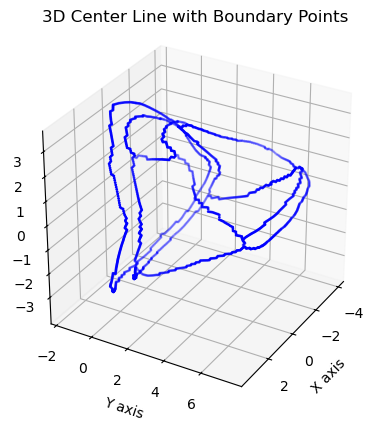

In [10]:
# 润
get_contour_lines(vertices, all_boundary_edges)

In [11]:
'''
暂时写道这种程度，下阶段有三个调整方案：
1.做更多次插值加密，以压缩轮廓线宽度；
2.加入形态学调整，并解决其与邻域投票的冲突；
3.为用于测量参数的轮廓线定制排序函数。
'''

'\n暂时写道这种程度，下阶段有三个调整方案：\n1.做更多次插值加密，以压缩轮廓线宽度；\n2.加入形态学调整，并解决其与邻域投票的冲突；\n3.为用于测量参数的轮廓线定制排序函数。\n'

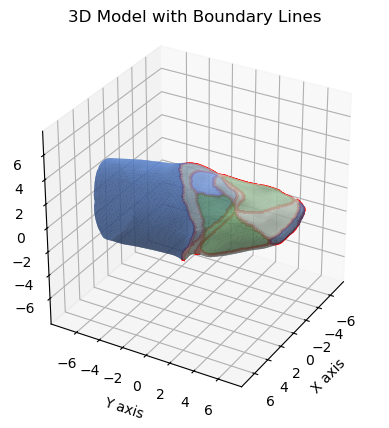

In [12]:
plot_surface_with_boundary_lines(vertices, faces, labels, all_boundary_edges, view_angles=(30, 30), angles=(np.radians(0), np.radians(0), np.radians(0)))
# ['Ya Gen', 'Qie Duan', 'Jin Zhong', 'Yuan Zhong', 'She Zhou Mian', 'Chun Mian', 'Jian Tai', 'She Mian Wo']

In [ ]:
'''
['Ya Gen', 'Qie Duan', 'Jin Zhong', 'Yuan Zhong', 'She Zhou Mian', 'Chun Mian', 'Jian Tai', 'She Mian Wo']
(1,2)
(2,3)(2,4)(2,6)(2,8)
(3,5)(3,6)(3,7)(3,8)
(4,5)(4,6)(4,7)(4,8)
(5,7)(5,8)
(6,7)
'''

In [ ]:
for i in range(7):
    for j in range(i+1,8):
        boundary_edges = all_boundary_edges[(i+1,j+1)]
        boundary_midpoints = calculate_midpoints(boundary_edges, np.array(vertices))

        if boundary_midpoints.size >0:
            if i==0 and j==6:
                '''牙根-肩台'''
                reference_point = np.array([0, 0, 0])  # 参考点
                reference_direction = np.array([0, 0, 1])  # 参考方向
            elif i==1 and j==2:
                '''切端-近中'''
                reference_point = np.array([0, 0, 6])  # 参考点
                reference_direction = np.array([0, 0, 1])  # 参考方向
            elif i==1 and j==3:
                '''切端-远中'''
                reference_point = np.array([0, 0, 6])  # 参考点
                reference_direction = np.array([0, 0, 1])  # 参考方向
            elif i==1 and j==5:
                '''切端-唇面'''
                reference_point = np.array([0, 6, 6])  # 参考点
                reference_direction = np.array([1, 0, 0])  # 参考方向
            elif i==1 and j==7:
                '''切端-舌面窝'''
                reference_point = np.array([0, 6, -6])  # 参考点
                reference_direction = np.array([1, 0, 0])  # 参考方向
            elif i==2 and j==4:
                '''近中-舌轴面'''
                reference_point = np.array([0, 0, 0])  # 参考点
                reference_direction = np.array([0, 1, 0])  # 参考方向
            elif i==2 and j==5:
                '''近中-唇面'''
                reference_point = np.array([0, -2, 0])  # 参考点
                reference_direction = np.array([0, 0, -1])  # 参考方向
            elif i==2 and j==6:
                '''近中-肩台'''
                reference_point = np.array([4, 6, 0])  # 参考点
                reference_direction = np.array([0, 0, 1])  # 参考方向
            elif i==2 and j==7:
                '''近中-舌面窝'''
                reference_point = np.array([4, 4, -4])  # 参考点
                reference_direction = np.array([0, 1, 0])  # 参考方向
            elif i==3 and j==4:
                '''远中-舌轴面'''
                reference_point = np.array([0, 0, 0])  # 参考点
                reference_direction = np.array([0, 1, 0])  # 参考方向
            elif i==3 and j==5:
                '''远中-唇面'''
                reference_point = np.array([0, -2, 0])  # 参考点
                reference_direction = np.array([0, 0, -1])  # 参考方向
            elif i==3 and j==6:
                '''远中-肩台'''
                reference_point = np.array([-4, 6, 0])  # 参考点
                reference_direction = np.array([0, 0, 1])  # 参考方向
            elif i==3 and j==7:
                '''远中-舌面窝'''
                reference_point = np.array([-4, 4, -4])  # 参考点
                reference_direction = np.array([0, 1, 0])  # 参考方向
            elif i==4 and j==6:
                '''舌轴面-肩台'''
                reference_point = np.array([0, 0, 0])  # 参考点
                reference_direction = np.array([0, 0, 1])  # 参考方向
            elif i==4 and j==7:
                '''舌轴面-舌面窝'''
                reference_point = np.array([0, 0, 0])  # 参考点
                reference_direction = np.array([0, 0, 1])  # 参考方向
            elif i==5 and j==6:
                '''唇面-肩台'''
                reference_point = np.array([0, 0, 0])  # 参考点
                reference_direction = np.array([0, 0, 1])  # 参考方向

            # 确保参考方向是单位向量
            reference_direction = reference_direction / np.linalg.norm(reference_direction)
            
            # 计算每个点与参考点的相对向量
            relative_points = boundary_midpoints - reference_point  # 计算相对坐标
            
            # 计算与参考方向的夹角
            angles = np.arccos(np.clip(np.dot(relative_points, reference_direction), -1.0, 1.0))
            
            # 获取排序的索引
            sorted_indices = np.argsort(angles)
            
            # 返回排序后的点集
            sorted_points = boundary_midpoints[sorted_indices]
